In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2021-11-02 18:47:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip’

household_power_con 100%[===================>]  19.68M  10.0MB/s    in 2.0s    

2021-11-02 18:47:18 (10.0 MB/s) - ‘household_power_consumption.zip’ saved [20640916/20640916]



In [2]:
!unzip household_power_consumption.zip

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv("household_power_consumption.txt", sep=";", parse_dates= {"date": ["Date", "Time"]}, infer_datetime_format=True, low_memory=False, na_values=["nan","?"], index_col='date').reset_index()
df.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.isna().sum()

date                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [6]:
columnsWithNa = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
for column in columnsWithNa :
    df[column].fillna(df[column].mean(), inplace = True)

In [7]:
df.isna().sum()

date                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
df_daily = df.resample('D', on='date').sum()

In [9]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [10]:
df_daily= df_daily.reset_index()

Text(0, 0.5, 'Global_active_power')

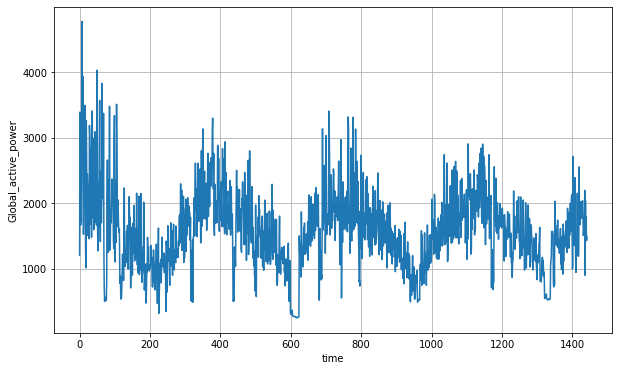

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Global_active_power, '-' )
plt.grid()
plt.xlabel('time')
plt.ylabel('Global_active_power')

In [12]:
#correlation
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


In [14]:
df_daily.shape

(1442, 8)

In [15]:
from fbprophet import Prophet
df1= df_daily.rename(columns={"date": "ds", "Global_active_power": "y"})
df1.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [16]:
train_df = df1[:1077]
test_df= df1[1077:]
print(train_df.shape)
print(test_df.shape)


(1077, 8)
(365, 8)


In [17]:
model= Prophet()
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
forecast= model.predict(test_df)
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
#yhat is the prediction while yhat_lower and yhat_upper are the lower and upper boundaries

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2009-11-27,2101.481147,1541.444745,2719.358003,1582.602983,1582.602983,1582.602983
1,2009-11-28,2404.822494,1857.296227,2956.554110,1582.737295,1582.737295,1582.737295
2,2009-11-29,2379.004539,1825.616437,2946.151235,1582.871607,1582.871607,1582.871607
3,2009-11-30,1979.262602,1407.050311,2490.709960,1583.005919,1583.005919,1583.005919
4,2009-12-01,2100.244401,1524.816310,2652.014006,1583.140231,1583.140231,1583.140231
...,...,...,...,...,...,...,...
360,2010-11-22,2038.931308,1499.272749,2617.632381,1630.955318,1618.520998,1643.342264
361,2010-11-23,2181.103668,1624.891400,2699.242071,1631.089630,1618.652636,1643.523430
362,2010-11-24,2192.185077,1606.482412,2734.444702,1631.223942,1618.734372,1643.737144
363,2010-11-25,2024.913261,1516.341579,2546.157096,1631.358254,1618.791878,1643.949270


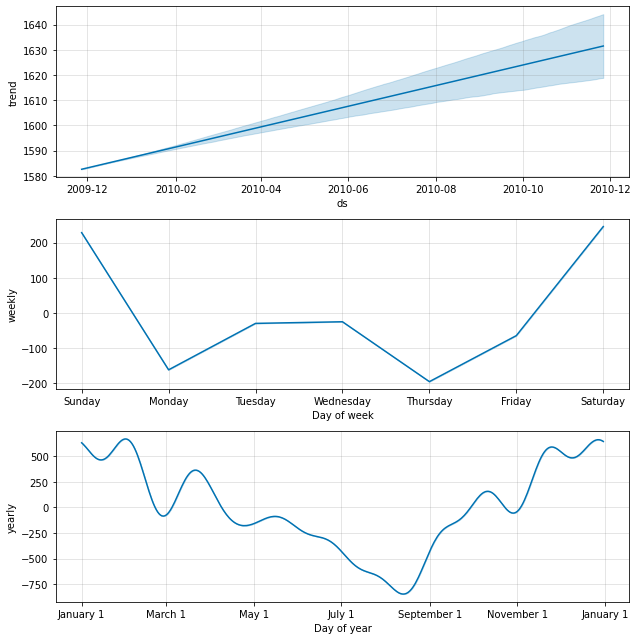

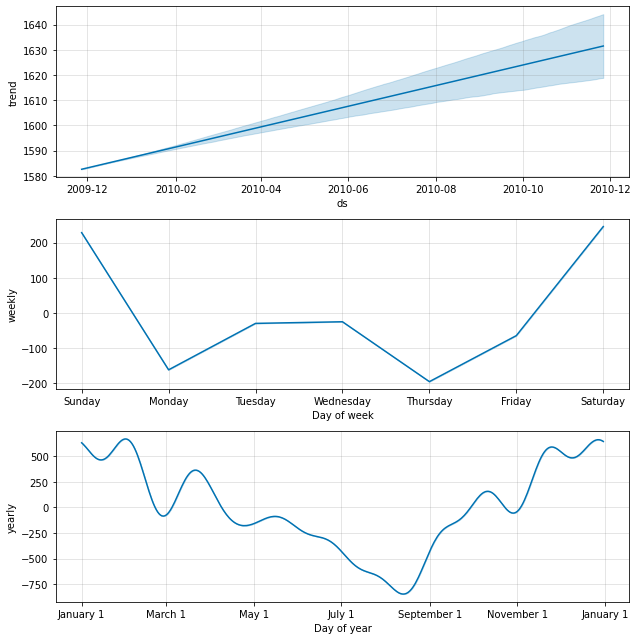

In [19]:
model.plot_components(forecast)

In [20]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE: {}'.format(round(mean_absolute_percentage_error(y_true=test_df['y'],
                   y_pred=forecast['yhat']),2)))

MAPE: 20.88


In [21]:
#root mean square error(rmse)
from sklearn.metrics import mean_squared_error
rmse= np.sqrt(mean_squared_error(y_true=test_df['y'], y_pred=forecast['yhat']))
print('RMSE: {}'.format(round(rmse, 2)))

RMSE: 374.95


In [22]:
df2= df1
train_df2 = df2[:1077]
test_df2= df2[1077:]
print(train_df.shape)
print(test_df.shape)


(1077, 8)
(365, 8)


In [23]:
model = Prophet()
model.add_regressor('Global_reactive_power')
model.add_regressor('Voltage')
model.add_regressor('Global_intensity')
model.add_regressor('Sub_metering_1')
model.add_regressor('Sub_metering_2')
model.add_regressor('Sub_metering_3')
model.fit(train_df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
#future= model.make_future_dataframe(periods=365)
forecast2= model.predict(test_df2)
forecast2.head()
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2009-11-27,1381.013965,1363.718149,1398.391957,1595.458562,1595.458562,1595.458562
1,2009-11-28,1861.835909,1845.784235,1878.244130,1595.579416,1595.579416,1595.579416
2,2009-11-29,1644.151802,1628.236466,1660.976738,1595.700269,1595.700269,1595.700269
3,2009-11-30,1742.715656,1726.383406,1758.894601,1595.821122,1595.821122,1595.821122
4,2009-12-01,1762.465224,1746.001256,1779.485473,1595.941976,1595.941976,1595.941976
...,...,...,...,...,...,...,...
360,2010-11-22,2115.514158,1837.506054,2400.706287,1638.965802,1367.303179,1924.610260
361,2010-11-23,1657.216211,1387.865317,1941.384571,1639.086655,1366.337597,1925.707134
362,2010-11-24,1864.612682,1590.867761,2152.866327,1639.207509,1365.268095,1926.804008
363,2010-11-25,1487.507380,1208.570199,1780.138980,1639.328362,1364.291601,1927.900882


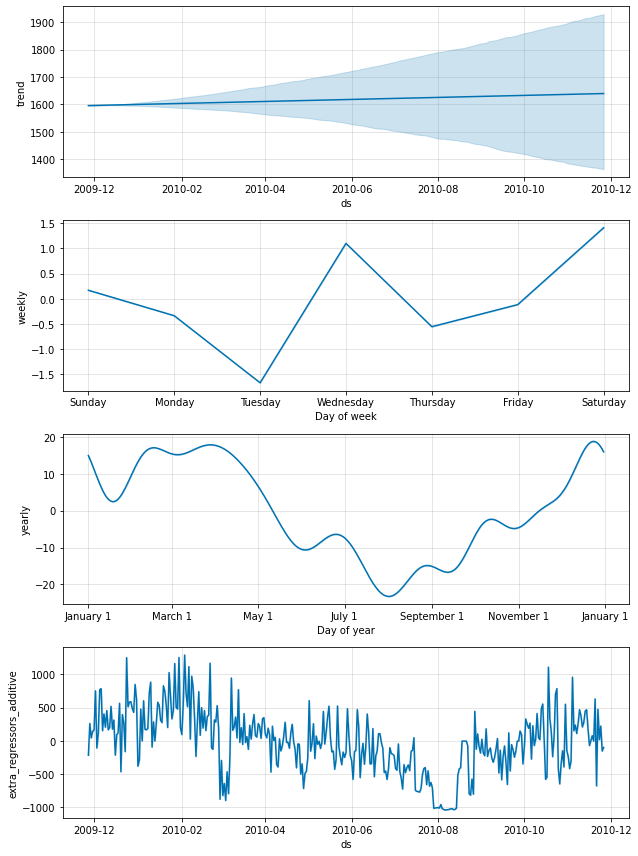

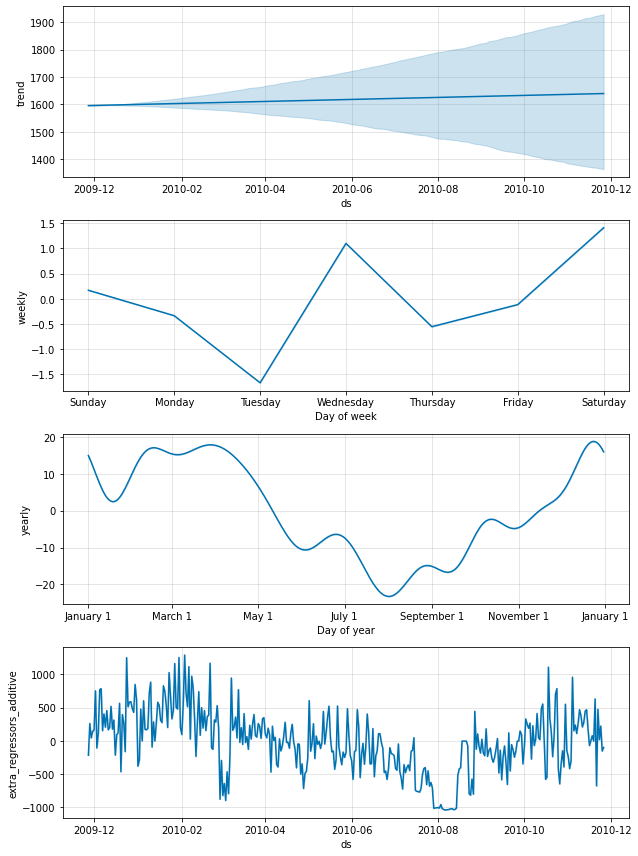

In [25]:
model.plot_components(forecast2)

In [26]:
print('MAPE: {}'.format(round(mean_absolute_percentage_error(y_true=test_df2['y'],
                   y_pred=forecast2['yhat']),2)))

MAPE: 2.63


In [27]:
rmse2= np.sqrt(mean_squared_error(y_true=test_df2['y'], y_pred=forecast2['yhat']))
print('RMSE: {}'.format(round(rmse2,2)))

RMSE: 39.13
